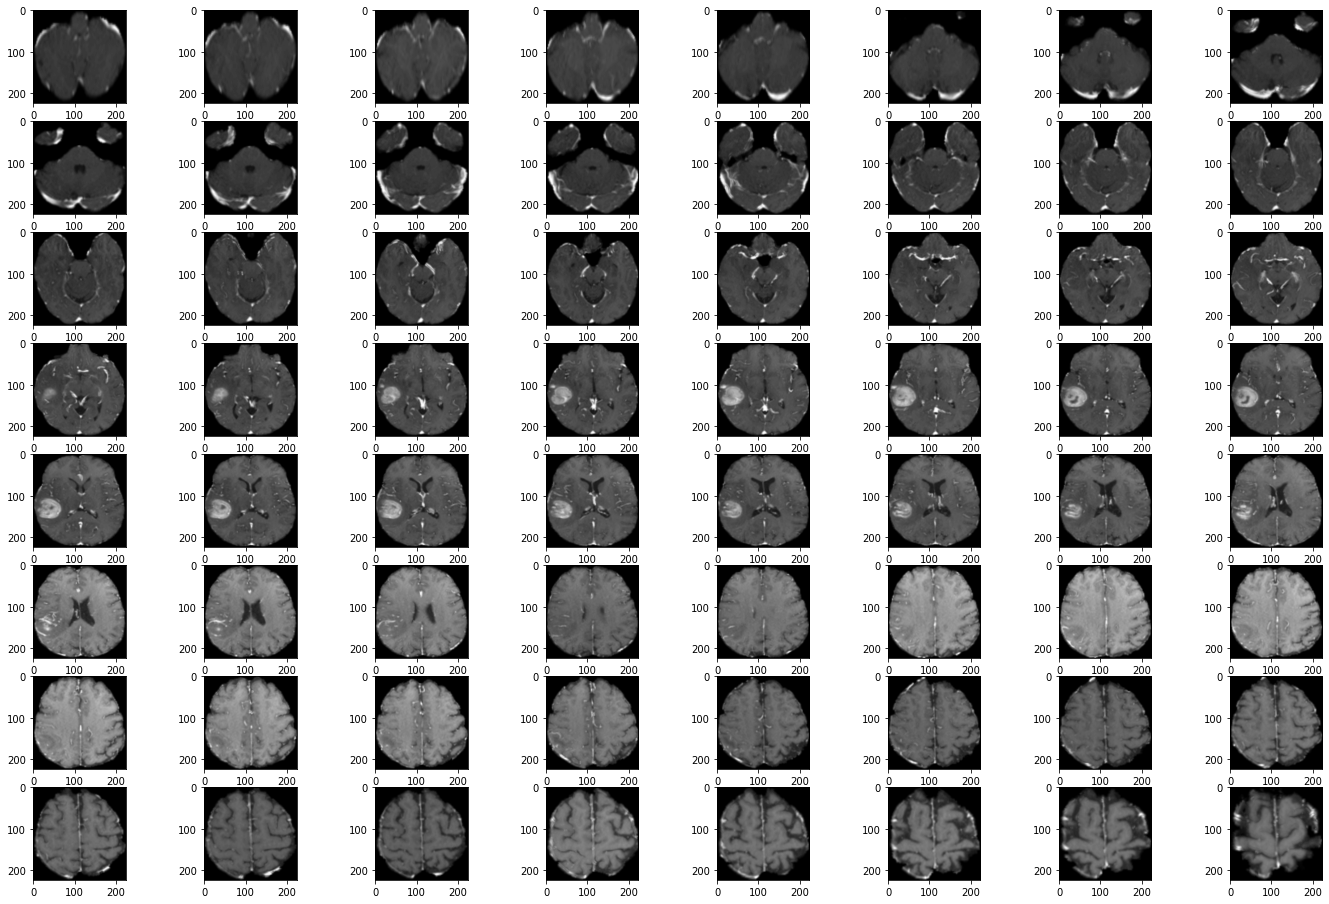

In [1]:
from torch import nn
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import cv2
from glob import glob
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from torch import optim
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


def getAugmentationParams(rot=[-10,10],brig=[-30,30],con=[-30,50]):
    result={'rotation':0,'flipImage':None,'brightness':0 ,'contrast':0}
    opt1=np.random.randint(0, 2)
    opt2=np.random.randint(0, 2)
    opt3=np.random.randint(0, 2)
    opt4=np.random.randint(0, 2)
    if opt1==1:
        result['rotation']=np.random.randint(rot[0],rot[1])
    if opt2==1:
        result['flipImage']=np.random.randint(-1,2)
    if opt3==1:
        result['brightness']=np.random.randint(brig[0],brig[1])
    if opt4==1:
        result['contrast']=np.random.randint(con[0],con[1])
    
    return result

def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def flipImage(img,code):
    '''
    code = 0: flip vertically
    code = 1: flip horizontally
    code = -1: flip vertically and horizontally
    '''
    if code is None:
        return img
    img_flip_ud = cv2.flip(img, code)
    return img_flip_ud


def apply_brightness_contrast(input_img, brightness = 0, contrast = 0):
    '''
    input img : cv2 image 
    brightness INT : number 
    contrast INT : number 
    '''
    
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow
        
        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()
    
    if contrast != 0:
        f = 131*(contrast + 127)/(127*(131-contrast))
        alpha_c = f
        gamma_c = 127*(1-f)
        
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf


def max_pool(img_list):
    img_list = np.array(img_list)
    max_img = img_list.max(axis=0)
    return max_img


def filter_images(img_list, img_size, threshold=0.9):
    final = []
    for img in img_list:
        if (np.count_nonzero(img == 0) / img_size**2) < threshold:
            final.append(img)
        elif (np.count_nonzero(img == 0) / img_size**2) == 1:
            final.append(img)
            
    return np.array(final)


def trim_empty_spaces(img_list, img_size):
    trimmed_list = []
    for img in img_list:
        try:
            trimmed = img[~np.all(img == 0, axis=1)]
            trimmed = trimmed.T[~np.all(trimmed.T == 0, axis=1)]
            trimmed = trimmed.T

            trimmed = cv2.resize(trimmed, (img_size, img_size))
            trimmed_list.append(trimmed)
        except:
            pass
        
    return np.array(trimmed_list)


def padding(img_list, num_imgs):
    temp = []
    for img in img_list:
        for _ in range(num_imgs//len(img_list)+1):
            temp.append(img)
            
    return np.array(temp)


def chunkIt(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0

    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg
    
    if len(out) > num:
        out = out[:num]
        
    return out


def load_slices_3d(path_to_scan_dir, num_imgs=64, img_size=224,augmentations=None):
    """
        path_to_scan_dir: the string to the scan location along with the mri type
        num_imgs: (integer) the number of the slices to get from the scan returns 3d tensor of shape (num_imgs, img_size, img_size)        
    """
    path_to_scan_dir = os.path.join(path_to_scan_dir, "*")
    slices_path = sorted(glob(path_to_scan_dir), key=lambda var: [int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])
    slices = [cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in slices_path]
    
    if augmentations is not None:
        slices = [ flipImage(x,augmentations['flipImage']) for x in slices ]        
        slices = [ apply_brightness_contrast(x,augmentations['brightness'],augmentations['contrast']) for x in slices ]
        slices = [ rotate_image(x,augmentations['rotation']) for x in slices ]
        

    slices = [cv2.resize(img, (img_size, img_size)) for img in slices]
    slices = filter_images(slices, img_size)
    slices = trim_empty_spaces(slices, img_size)

    if len(slices) < num_imgs:
        slices = padding(slices, num_imgs)

    slices = chunkIt(slices, num_imgs)
    averaged_slices = []
    for chunk in slices:
        averaged_slices.append(max_pool(chunk))
    tensor = np.array(averaged_slices)
    tensor = np.reshape(averaged_slices, (1, tensor.shape[0], tensor.shape[1], tensor.shape[2]))
    return torch.from_numpy(tensor).float()


class BrainTumorDataSet(Dataset):
    def __init__(self, scan_paths, labels_df, img_size=224, num_images=64,augmentations=False,rot=[-10,10],brig=[-30,30],con=[-30,50]):
        """
        Args:
            scan_paths: (list of strings) a list containing paths to the each scan. each training example.
            labels_df: dictionary[scan_id -> target]
            labels_df: (pandas dataframe) a pandas dataframe containing the scan_id and labels. with the index column set to the scan_ids
        """
        self.scan_paths = scan_paths
        self.labels_df = labels_df
        self.img_size = img_size
        self.num_images = num_images
        self.augmentations=augmentations
        self.rot=rot
        self.brig=brig
        self.con=con
        self.targets=labels_df

    def __len__(self, ):
        return len(self.scan_paths)

    def __getitem__(self, idx):
        self.label = np.eye(2)[self.targets[int(self.scan_paths[idx].split(os.sep)[-2])]]
        if self.augmentations:
            augment_params=getAugmentationParams(self.rot,self.brig,self.con)
        else:
            augment_params=None
        self.tensor = load_slices_3d(
            path_to_scan_dir=self.scan_paths[idx],
            num_imgs=self.num_images,
            img_size=self.img_size,
        )
        return (self.tensor, self.label)
    
    
def plot_image_grid(images, ncols=None, cmap='gray'):
    '''Plot a grid of images'''
    if not ncols:
        factors = [i for i in range(1, len(images)+1) if len(images) % i == 0]
        ncols = factors[len(factors) //
                        2] if len(factors) else len(images) // 4 + 1
    nrows = int(len(images) / ncols) + int(len(images) % ncols)
    imgs = [images[i] if len(
        images) > i else None for i in range(nrows * ncols)]
    f, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 2*nrows))
    axes = axes.flatten()[:len(imgs)]
    for img, ax in zip(imgs, axes.flatten()):
        if np.any(img):
            if len(img.shape) > 2 and img.shape[2] == 1:
                img = img.squeeze()
            ax.imshow(img, cmap=cmap)
            
imgs = np.array(load_slices_3d("../input/rsna-miccai-png/test/00287/T1wCE", 64)[0])
plot_image_grid(imgs)

In [2]:
!pip install git+https://github.com/shijianjian/EfficientNet-PyTorch-3D
from efficientnet_pytorch_3d import EfficientNet3D

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 1}, in_channels=1)
        n_features = self.net._fc.in_features
        self.net._fc = nn.Linear(in_features=n_features, out_features=2, bias=True)
    
    def forward(self, x):
        out = self.net(x)
        return out
    

  Cloning https://github.com/shijianjian/EfficientNet-PyTorch-3D to /tmp/pip-req-build-tjh_0f4_
  Running command git clone -q https://github.com/shijianjian/EfficientNet-PyTorch-3D /tmp/pip-req-build-tjh_0f4_
  Created wheel for efficientnet-pytorch-3d: filename=efficientnet_pytorch_3d-0.6.3-py3-none-any.whl size=16760 sha256=74591fbc81fadf58b9ac70368ba3c8734080afe52a09d769d67aff494aaa937e
  Stored in directory: /tmp/pip-ephem-wheel-cache-7xxx5kwd/wheels/ea/44/3d/89ce0e32ed262cff6c10d0586dc8f82bbb8ba1eeb47863abe5
Successfully built efficientnet-pytorch-3d


In [3]:
class Trainer:
    def __init__(self, model, criterion, optimizer, device, metric='auc'):
        self.model = model.to(device=device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        if metric == 'auc':
            self.metric = roc_auc_score
        else:
            self.metric == metric
        self.best_val_loss = np.inf
        self.patience = 0
    
    @staticmethod
    def logger(message, *args, end="\n"):
        print(message.format(*args), end=end)    
    
    
    def fit(self, trainLoader, validLoader, save_path, epochs=10, patience=3):
        self.logger("Training Started at: {}", time.ctime())
        
        for epoch in range(1, epochs+1):
            train_loss, train_time = self.train_epoch(trainLoader)
            self.logger("Epoch {} Train  ||  loss: {:.4f}  ||  Time taken {:.1f}s", epoch, train_loss, train_time)            
            val_loss, val_accuracy, val_time = self.valid_epoch(validLoader)
            self.logger("Epoch {} Valid  ||  loss: {:.4f}  ||  accuracy: {:.4f}  ||  Time taken {:.1f}s", epoch, val_loss, val_accuracy, val_time)
            
            
            if self.best_val_loss > val_loss:
                self.save_model(epoch, save_path, val_loss, val_accuracy)
                self.logger("Validation Loss imporoved from {:.4f} to {:.4f}. Saving the model", self.best_val_loss, val_loss)
                self.best_val_loss = val_loss
                self.patience = 0
            else:
                self.patience += 1
            if self.patience >= patience:
                self.logger("\nValid auc didn't improve last {} epochs. Early Stopping", patience)
                break
            self.logger("--------------------------------")
    
    
    def train_epoch(self, trainLoader):
        tick = time.time()
        sum_loss = 0
        allOutputs, allTargets = [], []
        self.model.train()

        for idx, (X, targets) in enumerate(trainLoader):
            X = X.to(device=self.device)
            targets = targets.to(device=self.device).float()

            self.optimizer.zero_grad()
            
            outputs = self.model(X).squeeze(1)
            loss = self.criterion(outputs, targets)

            loss.backward()
            sum_loss += loss.detach().item()
            self.optimizer.step()
            
            self.logger("Training Batch {}/{}  ||  loss: {:.4f} ", idx+1, len(trainLoader), loss, end='\r')
        
        return sum_loss/len(trainLoader), time.time()-tick
        
        
    def valid_epoch(self, validLoader):
        self.model.eval()
        tick = time.time()
        sum_loss = 0
        allOutputs, allTargets = [], []

        for idx, (X, targets) in enumerate(validLoader):
            with torch.no_grad():
                X = X.to(device=self.device)
                targets = targets.to(device=self.device).float()
                
                outputs = model(X).squeeze(1)
                loss = self.criterion(outputs, targets)
                
                sum_loss += loss.detach().item()
                allTargets.extend(targets.tolist())
                allOutputs.extend(torch.sigmoid(outputs).tolist())
                
            self.logger("Validating Batch {}/{}  ||  loss: {:.4f} ", idx+1, len(validLoader), loss, end='\r')

#         allTargets = [max(x) for x in allTargets]
#         auc = self.metric(allTargets, allOutputs)
        auc = 0.0001
        return sum_loss/len(validLoader), auc, time.time()-tick
    
    
    def save_model(self, n_epoch, save_path, loss, auc):
        self.lastmodel = f"RSNA-{save_path}-e{n_epoch}-loss{loss:.3f}-auc{auc:.3f}.pth"
        
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_val_loss,
                "n_epoch": n_epoch,
            },
            self.lastmodel,
        )



In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 4
EPOCHS = 5
IMG_SIZE = 256
NUM_IMGS = 64
PATIENCE = 5
LEARNING_RATE = 0.00008
MRI_TYPE = "FLAIR"

model = Model()

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

data_directory="../input/rsna-miccai-brain-tumor-radiogenomic-classification"
labels_df= pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")

train_x,test_x,trainy,test_y=  train_test_split(labels_df,labels_df['MGMT_value'],test_size =0.2)
file_train_list= train_x.BraTS21ID.astype(str).str.zfill(5)
file_valid_list= test_x.BraTS21ID.astype(str).str.zfill(5)
validation_file_list = [ x  for x in glob('../input/rsna-miccai-png/train/*/{}'.format(MRI_TYPE)) if x.split(os.sep)[-2] in file_valid_list.values  ]
train_file_list = [ x  for x in glob('../input/rsna-miccai-png/train/*/{}'.format(MRI_TYPE)) if x.split(os.sep)[-2] in file_train_list.values  ]


trainDataSet= BrainTumorDataSet(
train_file_list, labels_df = {x[1]:x[2] for x in  labels_df.itertuples()}, img_size=IMG_SIZE, num_images=NUM_IMGS,
    augmentations=True
)

testDataSet= BrainTumorDataSet(
validation_file_list, labels_df = {x[1]:x[2] for x in  labels_df.itertuples()}, img_size=IMG_SIZE, num_images=NUM_IMGS,
    augmentations=False
)

trainLoader = DataLoader(trainDataSet, batch_size=BATCH_SIZE, prefetch_factor=2)
testLoader = DataLoader(testDataSet, batch_size=BATCH_SIZE, prefetch_factor=2)

In [5]:
trainer = Trainer(model, criterion, optimizer, device)
trainer.fit(trainLoader, testLoader, "FLAIR", EPOCHS, PATIENCE)

Training Started at: Fri Sep  3 04:09:28 2021
Epoch 1 Train  ||  loss: 0.7008  ||  Time taken 479.0s
Epoch 1 Valid  ||  loss: 0.6936  ||  accuracy: 0.0001  ||  Time taken 93.2s
Validation Loss imporoved from inf to 0.6936. Saving the model
--------------------------------
Epoch 2 Train  ||  loss: 0.5827  ||  Time taken 327.8s
Epoch 2 Valid  ||  loss: 0.6969  ||  accuracy: 0.0001  ||  Time taken 52.7s
--------------------------------
Epoch 3 Train  ||  loss: 0.4635  ||  Time taken 328.6s
Epoch 3 Valid  ||  loss: 0.6985  ||  accuracy: 0.0001  ||  Time taken 51.7s
--------------------------------
Epoch 4 Train  ||  loss: 0.3781  ||  Time taken 330.4s
Epoch 4 Valid  ||  loss: 0.7146  ||  accuracy: 0.0001  ||  Time taken 53.7s
--------------------------------
Epoch 5 Train  ||  loss: 0.3586  ||  Time taken 350.1s
Epoch 5 Valid  ||  loss: 0.7060  ||  accuracy: 0.0001  ||  Time taken 62.8s
--------------------------------
